In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import warnings
import model_report as mr
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df_train = pd.read_csv('C:\\Users\\blgai\\OneDrive\\Documents\\School\\SMU\\Courses\\Fall 2021\\Capstone A\Data\\train_keywords_v1.csv')
df_test = pd.read_csv('C:\\Users\\blgai\\OneDrive\\Documents\\School\\SMU\\Courses\\Fall 2021\\Capstone A\Data\\test_keywords_v1.csv')
df_holdout = pd.read_csv('C:\\Users\\blgai\\OneDrive\\Documents\\School\\SMU\\Courses\\Fall 2021\\Capstone A\Data\\holdout_keywords_v1.csv')

In [3]:
#training data
X_train = df_train['clean_key_words']
y_train = df_train['category']

#test data
X_test = df_test['clean_key_words']
y_test = df_test['category']

#holdout data
X_holdout = df_holdout['clean_key_words']
y_holdout = df_holdout['category']

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

#build BOW features on train corpus
tv = TfidfVectorizer(use_idf=True, min_df=25,max_df=.9, norm="l2",smooth_idf=True)
tv_train_features = tv.fit_transform(X_train)
#transform test corpus into features
tv_test_features = tv.transform(X_test)
#transform holdout corpus into features
tv_holdout_features = tv.transform(X_holdout)

In [6]:
#Let's find the top important features and analyze them

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X_opt=SelectKBest(chi2, k=2000)
tv_train_features_trimmed = X_opt.fit_transform(tv_train_features, y_train)
tv_train_features_trimmed.shape

(29302, 2000)

In [7]:
#create a data frame that includes all features and whether or not they are deemed important by feature_selection
feat_imp = pd.DataFrame(list(zip(tv.get_feature_names(),X_opt.get_support().tolist())),columns = ['Features','Important'])
feat_imp[feat_imp.Important == True]

,Features,Important
2,abroad,True
6,academic,True
7,academy,True
8,accept,True
9,access,True
...,...,...
2930,yield,True
2932,york,True
2933,young,True
2934,youth,True


In [8]:
#Now we can grab the important features so that we can select only the important features from the sparse matrix created by TfidfVectorizer
imp_Feats_array = np.array(feat_imp[feat_imp.Important == True].index)

In [9]:
#Now we can pull only the important features out of the original train, test, and holdout matrices
tv_train_features_sub = tv_train_features[:,imp_Feats_array]
tv_test_features_sub = tv_test_features[:,imp_Feats_array]
tv_holdout_features_sub = tv_holdout_features[:,imp_Feats_array]

#Examine the new shapes of the sub-selected features
print('TFIDF model:> Train features shape:',tv_train_features_sub.shape,'Test features shape:',tv_test_features_sub.shape,'Holdout features shape:',tv_holdout_features_sub.shape)

TFIDF model:> Train features shape: (29302, 2000) Test features shape: (8386, 2000) Holdout features shape: (4188, 2000)


In [10]:
%%time

from sklearn import svm
clf = svm.SVC(kernel='linear', probability=True, C=1.0, class_weight={'dr':8,'sx':10},random_state=1234)
clf.fit(tv_train_features_sub,y_train)

Wall time: 4min 20s


SVC(class_weight={'dr': 8, 'sx': 10}, kernel='linear', probability=True,
    random_state=1234)

In [11]:
svm_tfidf_test_score = clf.score(tv_test_features_sub,y_test)
print('Test Accuracy:',svm_tfidf_test_score)

Test Accuracy: 0.7644884331027904


In [12]:
import model_evaluation_utils as meu
svm_predictions = clf.predict(tv_test_features_sub)
meu.get_metrics(true_labels=y_test,predicted_labels=svm_predictions)

Accuracy: 0.7645
Precision: 0.7654
Recall: 0.7645
F1 Score: 0.7636


In [13]:
unique_classes = list(set(y_test))
meu.display_classification_report(true_labels=y_test,predicted_labels=svm_predictions,classes=unique_classes)

              precision    recall  f1-score   support

          mk       0.64      0.65      0.64      1709
          bu       0.74      0.80      0.77      2355
          os       0.73      0.66      0.69      1393
          sx       0.94      0.97      0.95      1345
          dr       0.87      0.90      0.88       307
          ed       0.82      0.70      0.76       783
          sp       0.81      0.73      0.77       494

    accuracy                           0.76      8386
   macro avg       0.79      0.77      0.78      8386
weighted avg       0.77      0.76      0.76      8386



Confusion matrix, without normalization
[[ 919   25   17   20  236   18  158]
 [  17  552    5   21   54   12  122]
 [  11    0  275    1    4    6   10]
 [  23   24    4  360   45   11   27]
 [ 158   30    6   34 1117   19  345]
 [   8    4    1    0   14 1305   13]
 [ 118   37    9    6  285   17 1883]]


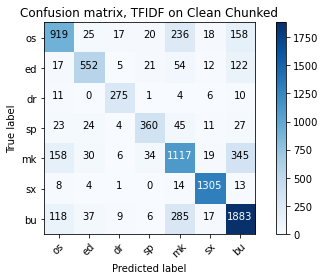

In [14]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test,svm_predictions,labels=['os','ed','dr','sp','mk','sx','bu'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
mr.plot_confusion_matrix(cnf_matrix, classes=['os','ed','dr','sp','mk','sx','bu'],
                      title='Confusion matrix, TFIDF on Clean Chunked')

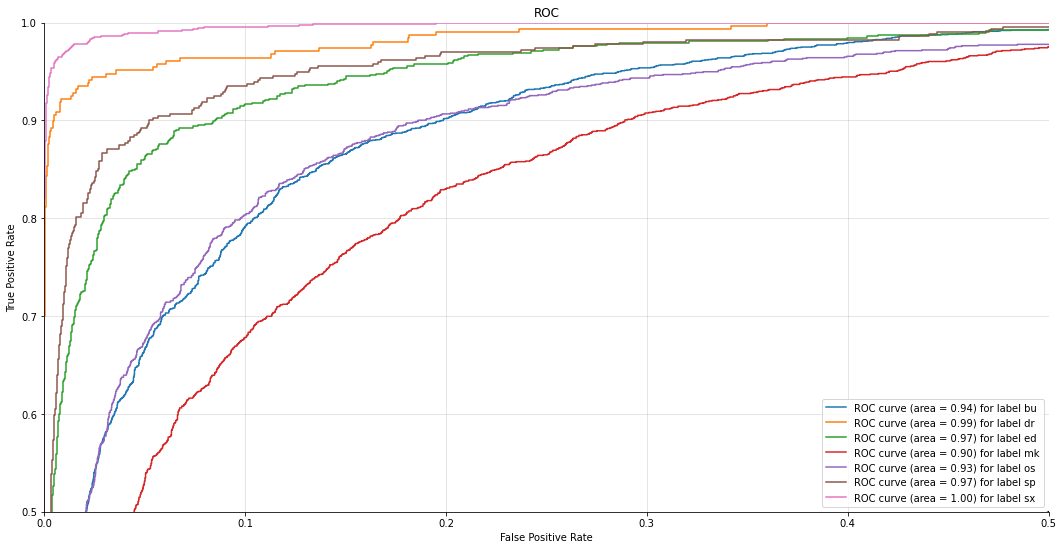

In [15]:
y_proba = clf.predict_proba(tv_test_features_sub)

labels_dict = dict(zip(y_train,y_train))
target_names = sorted(list(labels_dict.values()))

mr.plot_roc_curve(labels=y_test, predictions=y_proba, x_lim=[0.0,0.5], y_lim=[0.5,1.0], target_names=target_names)

In [17]:
df_test_results = pd.DataFrame(list(zip(y_test,svm_predictions, y_proba)),columns = ['category','predicted_label','probability'])
df_test_results['match'] = np.where(df_test_results['category']==df_test_results['predicted_label'],1,0)

In [18]:
rpt = mr.generate_report(df_test_results)
rpt

{'totalSamples': 8386,
 'overallAccuracy': 0.7644884331027904,
 'byCategory': {'sx': {'totalSamples': 1345, 'accuracy': 0.9702602230483272},
  'dr': {'totalSamples': 307, 'accuracy': 0.8957654723127035},
  'bu': {'totalSamples': 2355, 'accuracy': 0.7995753715498939},
  'sp': {'totalSamples': 494, 'accuracy': 0.728744939271255},
  'ed': {'totalSamples': 783, 'accuracy': 0.7049808429118773},
  'os': {'totalSamples': 1393, 'accuracy': 0.659727207465901},
  'mk': {'totalSamples': 1709, 'accuracy': 0.6535985956699825}}}

In [19]:
#pickle the model
import pickle

filename = 'svm_keywords_v1.sav'
pickle.dump(clf,open(filename,'wb'))

In [20]:
#pickle the data

#training data
filename = 'tv_train_features_sub_keywords_v1.pkl'
pickle.dump(tv_train_features_sub,open(filename,'wb'))

#test data
filename = 'tv_test_features_sub_keywords_v1.pkl'
pickle.dump(tv_test_features_sub,open(filename,'wb'))

#holdout data
filename = 'tv_holdout_features_sub_keywords_v1.pkl'
pickle.dump(tv_holdout_features_sub,open(filename,'wb'))

#save labels
pickle.dump(y_train, open('train_label_keywords.pkl','wb'))
pickle.dump(y_test, open('test_label_keywords.pkl','wb'))
pickle.dump(y_holdout, open('holdout_label_keywords.pkl','wb'))